## Generation of sci-Plex perturbation response

### (1) Train and load PerturbNet on sci-Plex data

In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
import sys
sys.path.append('../../..')
import time
import os
import random 

import torch
import torch.nn.functional as F
import torch.nn as nn

import anndata as ad
import scvi
from sklearn.decomposition import PCA

from pytorch_scvi.distributions import *
from pytorch_scvi.scvi_generate_z import *

from perturbnet.perturb.util import * 
from perturbnet.perturb.cinn.modules.flow import * 
from perturbnet.perturb.chemicalvae.chemicalVAE import *
from perturbnet.perturb.cinn.modules.flow_generate import SCVIZ_CheckNet2Net


In [2]:
# (1) load data 
## directories
path_save = 'output'
if not os.path.exists(path_save):
    os.makedirs(path_save, exist_ok = True)

path_data = 'data/'
path_chemvae_model = 'model/chemvae/model_params.pt'
path_scvi_model_eval = 'models/models_scip3AllGenesSelected_10'
path_scvi_model_cinn = 'models/models_scip3AllGenesSelected_10_30Removed'

path_cinn_model = 'models/ExpscviVAEFlowInChem10GenesSelectedStdRemoved'
path_sciplex_onehot = 'data/OnehotData_188.npy'
path_chem_onehot = 'data/OnehotData_ZINC.npy'
path_removed_per = 'data/'
path_std_param = 'model/chemvae/'


## evalution scvi
adata = ad.read_h5ad(os.path.join(path_data, 'sciPlex3_whole_filtered_NormBYHighGenes_processed.h5ad')) 
scvi.data.setup_anndata(adata, layer = "counts")
scvi_model_eval = scvi.model.SCVI.load(path_scvi_model_eval, adata, use_cuda = False)

## sciplex trts
trt_list = list(pd.read_csv(os.path.join(path_data, 'emb_named_PathwayLibrary.csv'))['treatment'])

## onehot
data_sciplex_onehot = np.load(path_sciplex_onehot)
data_chem_onehot = np.load(path_chem_onehot)

## meta information
input_ltpm_label = adata.obs.copy()

## removed perturbations
trt_cell_type_no = ['S0000', 'nan']
list_c_trt = list(input_ltpm_label['treatment'])
idx_to_train = [i for i in range(len(list_c_trt)) if list_c_trt[i] not in trt_cell_type_no]

## removed perturbations
perturb_with_onehot_overall = np.array(list(input_ltpm_label['treatment']))
input_ltpm_label = input_ltpm_label.iloc[idx_to_train, :]
perturb_with_onehot = perturb_with_onehot_overall[idx_to_train]

removed_all_pers = np.load(os.path.join(path_data, "sciplex_30RemovedPerturbs.npy"))

kept_indices = [i for i in range(len(perturb_with_onehot)) if perturb_with_onehot[i] not in removed_all_pers]
input_ltpm_label1 = input_ltpm_label.iloc[kept_indices, :]
input_ltpm_label1.index = list(range(input_ltpm_label1.shape[0]))

perturb_with_onehot_kept = perturb_with_onehot[kept_indices]

# perturbation information 
data_trt = pd.read_csv(os.path.join(path_data, 'emb_named_chemvae_canonize.csv'))
data_trt['Indices'] = list(range(data_trt.shape[0]))

cell_embdata = input_ltpm_label1.loc[:, ['treatment']].merge(data_trt, how = 'left', on = 'treatment')
indices_onehot = list(cell_embdata['Indices'])

data_sciplexKept_onehot = data_sciplex_onehot[indices_onehot]

# (2) load models
## generation scvi 
adata_train = adata[idx_to_train, :].copy()
adata_train = adata_train[kept_indices, :].copy()

scvi.data.setup_anndata(adata_train, layer = "counts")
scvi_model_cinn = scvi.model.SCVI.load(path_scvi_model_cinn, adata_train, use_cuda = False)
scvi_model_de = scvi_predictive_z(scvi_model_cinn)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## ChemicalVAE
model_chemvae = ChemicalVAE(n_char = data_chem_onehot.shape[2], max_len = data_chem_onehot.shape[1]).to(device)
model_chemvae.load_state_dict(torch.load(path_chemvae_model, map_location = device))
model_chemvae.eval()

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 648857 cells, 5087 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

ChemicalVAE(
  (conv_1): Conv1d(120, 9, kernel_size=(9,), stride=(1,))
  (conv_2): Conv1d(9, 9, kernel_size=(9,), stride=(1,))
  (conv_3): Conv1d(9, 10, kernel_size=(11,), stride=(1,))
  (bnConv1): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnConv2): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnConv3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_0): Linear(in_features=90, out_features=196, bias=True)
  (linear_1): Linear(in_features=196, out_features=196, bias=True)
  (linear_2): Linear(in_features=196, out_features=196, bias=True)
  (dropout1): Dropout(p=0.08283292970479479, inplace=False)
  (bn1): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.08283292970479479, inplace=False)
  (bn2): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_3): Linear(in_features=196, 

In [3]:
# i) estimate latent means and stds
std_model = Standardize(data_all = data_chem_onehot, model = model_chemvae, device = device)

# ii) load from estimated means and stds
# mu_std_model = np.load(os.path.join(path_std_param, 'mu.npy'))
# std_std_model = np.load(os.path.join(path_std_param, 'std.npy'))
# std_model = StandardizeLoad(mu_std_model, std_std_model, device)


if sparse.issparse(adata.X):
    usedata = adata.X.A
else:
    usedata = adata.X

if sparse.issparse(adata.layers['counts']):
    usedata_count = adata.layers['counts'].A
else:
    usedata_count = adata.layers['counts']


flow_model = ConditionalFlatCouplingFlow(conditioning_dim = 196,
                                         # condition dimensions 
                                         embedding_dim = 10, 
                                         conditioning_depth = 2, 
                                         n_flows = 20, 
                                         in_channels = 10, 
                                         hidden_dim = 1024, 
                                         hidden_depth = 2, 
                                         activation = "none", 
                                         conditioner_use_bn = True)


model_c = Net2NetFlow_scVIChemStdFlow(configured_flow = flow_model,
                                      first_stage_data = usedata_count[idx_to_train][kept_indices], 
                                      cond_stage_data = data_sciplexKept_onehot, 
                                      model_con = model_chemvae, 
                                      scvi_model = scvi_model_cinn, 
                                      std_model = std_model)


model_c.to(device = device)
# (1) train
model_c.train(n_epochs = 50, batch_size = 128, lr = 4.5e-6)
# (2) evaluation
model_c.load(path_cinn_model)
model_c.eval()

model_g = model_c.model_con
model_g.eval()

Note: Conditioning network uses batch-normalization. Make sure to train with a sufficiently large batch size
[Epoch 1/1] [Batch 1/1] [loss: 4.275233/4.923659]


ChemicalVAE(
  (conv_1): Conv1d(120, 9, kernel_size=(9,), stride=(1,))
  (conv_2): Conv1d(9, 9, kernel_size=(9,), stride=(1,))
  (conv_3): Conv1d(9, 10, kernel_size=(11,), stride=(1,))
  (bnConv1): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnConv2): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnConv3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_0): Linear(in_features=90, out_features=196, bias=True)
  (linear_1): Linear(in_features=196, out_features=196, bias=True)
  (linear_2): Linear(in_features=196, out_features=196, bias=True)
  (dropout1): Dropout(p=0.08283292970479479, inplace=False)
  (bn1): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.08283292970479479, inplace=False)
  (bn2): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_3): Linear(in_features=196, 

In [4]:
perturbnet_model = SCVIZ_CheckNet2Net(model_c, device, scvi_model_de)

In [5]:
ZsampleAll = scvi_model_eval.get_latent_representation(adata = adata, give_mean = True)

In [6]:
usedata.shape, ZsampleAll.shape

((648857, 5087), (648857, 10))

In [ ]:
pca_data_50 = PCA(n_components=50, random_state = 42)
pca_data_50_lat = PCA(n_components=50, random_state = 42)

pca_data_fit = pca_data_50.fit(usedata)
pca_data_lat_fit = pca_data_50_lat.fit(ZsampleAll)

In [8]:
Zsample = scvi_model_cinn.get_latent_representation(adata = adata, give_mean = False)
LSample = scvi_model_cinn.get_latent_library_size(adata = adata, give_mean = False)

indices_trt_removed = [i for i in range(len(trt_list)) if trt_list[i] in removed_all_pers]
indices_trt_kept = [i for i in range(len(trt_list)) if i not in set(indices_trt_removed)]

trt_obs_list, trt_unseen_list = np.array(trt_list)[indices_trt_kept], np.array(trt_list)[indices_trt_removed]
save_results = SaveEvaluationResults("PerturbNet_Recon", "PerturbNet_Sample")


In [9]:
# Let the first 
indice_trt = 0
trt_type = trt_obs_list[indice_trt]

idx_trt_type = np.where(perturb_with_onehot_overall == trt_type)[0]

onehot_indice_trt = np.tile(data_sciplex_onehot[indices_trt_kept][[indice_trt]], (len(idx_trt_type), 1, 1))
_, _, _, embdata_torch = model_g(torch.tensor(onehot_indice_trt).float().to(device))

## recon data
input_trt_latent, trt_onehot = Zsample[idx_trt_type], std_model.standardize_z(embdata_torch.cpu().detach().numpy())
library_trt_latent = LSample[idx_trt_type]

In [10]:
fake_latent, fake_data = perturbnet_model.recon_data(input_trt_latent, trt_onehot, library_trt_latent)

### (2) Evaluation

In [12]:
import umap
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from plotnine import *
%matplotlib inline

In [19]:
trans = umap.UMAP(random_state=42, min_dist = 0.5, n_neighbors=30).fit(input_trt_latent)
x_embedded = trans.transform(np.concatenate((input_trt_latent, fake_latent)))

In [21]:
category = np.append(['S1172'] * input_trt_latent.shape[0], 
                     ['S1172_CINN'] * input_trt_latent.shape[0])
df_umap_pr = x_embedded#[n_data:]
df_umap_pr = pd.DataFrame(df_umap_pr)
df_umap_pr['x-umap'] =  x_embedded[:, 0]
df_umap_pr['y-umap'] =  x_embedded[:, 1]
df_umap_pr['Category'] = category

min_x, min_y = np.floor(df_umap_pr['x-umap'].min()), np.floor(df_umap_pr['y-umap'].min())
max_x, max_y = np.ceil(df_umap_pr['x-umap'].max()), np.ceil(df_umap_pr['y-umap'].max())


chart_pr = ggplot(df_umap_pr, aes(x= 'x-umap', y= 'y-umap', colour = 'Category') ) \
		+ geom_point(size=0.1, alpha = 1) + labs(x = "UMAP1", y = "UMAP2") \
		+ xlim(min_x, max_x) + ylim(min_y, max_y) + theme_bw()\
		+ theme(panel_background=element_rect(fill='white'), 
				title=element_text(size = 25), 
				axis_title_x=element_text(size = 15), 
				axis_title_y=element_text(size = 15),
				legend_title=element_text(size = 20), 
				legend_text=element_text(size = 20),                                                                                                               
				axis_text_y=element_blank(),
				axis_text_x=element_blank(),                                                                                                     
				axis_ticks_major_y=element_blank(),
				axis_ticks_major_x=element_blank(),                                    
				panel_grid=element_blank())\
		+ guides(colour=guide_legend(nrow=3, override_aes={"size": 10}))


/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):


/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


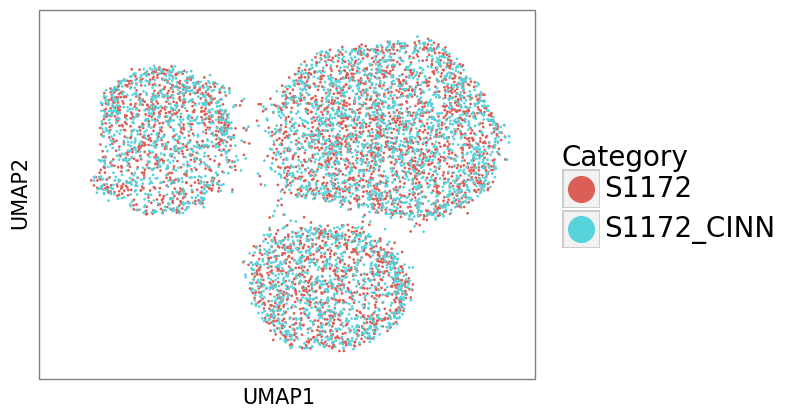

<ggplot: (2946249114905)>

In [25]:
chart_pr

In [15]:
fake_latent, fake_data = perturbnet_model.sample_data(trt_onehot, library_trt_latent)

In [27]:
trans = umap.UMAP(random_state=42, min_dist = 0.5, n_neighbors=30).fit(input_trt_latent)
x_embedded = trans.transform(np.concatenate((input_trt_latent, fake_latent)))

category = np.append(['S1172'] * input_trt_latent.shape[0], 
                     ['S1172_CINN_N(0, 1)'] * input_trt_latent.shape[0])
df_umap_pr = x_embedded#[n_data:]
df_umap_pr = pd.DataFrame(df_umap_pr)
df_umap_pr['x-umap'] =  x_embedded[:, 0]
df_umap_pr['y-umap'] =  x_embedded[:, 1]
df_umap_pr['Category'] = category

min_x, min_y = np.floor(df_umap_pr['x-umap'].min()), np.floor(df_umap_pr['y-umap'].min())
max_x, max_y = np.ceil(df_umap_pr['x-umap'].max()), np.ceil(df_umap_pr['y-umap'].max())


chart_pr = ggplot(df_umap_pr, aes(x= 'x-umap', y= 'y-umap', colour = 'Category') ) \
		+ geom_point(size=0.1, alpha = 1) + labs(x = "UMAP1", y = "UMAP2") \
		+ xlim(min_x, max_x) + ylim(min_y, max_y) + theme_bw()\
		+ theme(panel_background=element_rect(fill='white'), 
				title=element_text(size = 25), 
				axis_title_x=element_text(size = 15), 
				axis_title_y=element_text(size = 15),
				legend_title=element_text(size = 20), 
				legend_text=element_text(size = 20),                                                                                                               
				axis_text_y=element_blank(),
				axis_text_x=element_blank(),                                                                                                     
				axis_ticks_major_y=element_blank(),
				axis_ticks_major_x=element_blank(),                                    
				panel_grid=element_blank())\
		+ guides(colour=guide_legend(nrow=3, override_aes={"size": 10}))


/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):


/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


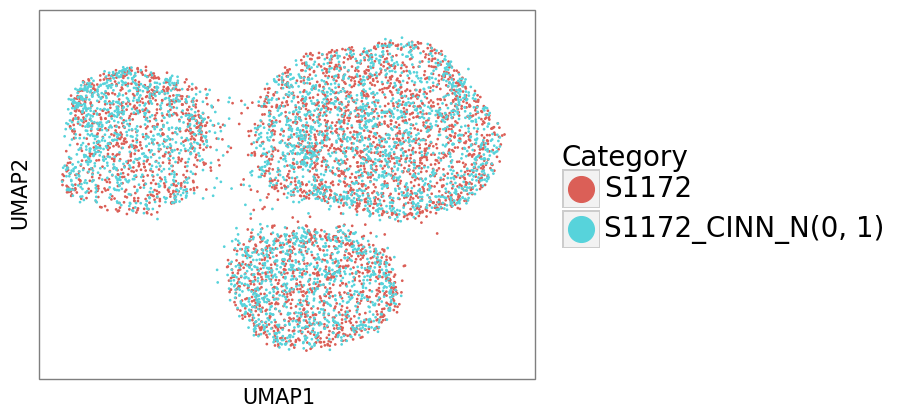

<ggplot: (2946319340924)>

In [28]:
chart_pr

### (3) Translation to another perturbation

In [16]:
trt_obs_list

array(['S1172', 'S2818', 'S1140', 'S2003', 'S1443', 'S1169', 'S1315',
       'S1068', 'S1319', 'S1032', 'S1628', 'S1001', 'S1124', 'S1622',
       'S1191', 'S1030', 'S2736', 'S7792', 'S1171', 'S1012', 'S1056',
       'S1261', 'S3001', 'S1033', 'S1021', 'S1007', 'S7110', 'S2179',
       'S1689', 'S1364', 'S1297', 'S1463', 'S1259', 'S1153', 'S1672',
       'S1454', 'S7165', 'S1515', 'S7582', 'S1289', 'S1156', 'S2014',
       'S7128', 'S3147', 'S1680', 'S1264', 'S1147', 'S7144', 'S2740',
       'S1280', 'S1451', 'S1069', 'S1392', 'S2718', 'S2851', 'S2779',
       'S1278', 'S2886', 'S2178', 'S2693', 'S1002', 'S1776', 'S1192',
       'S2673', 'S1055', 'S2198', 'S2692', 'S2806', 'S1048', 'S1178',
       'S1040', 'S1845', 'S7591', 'S1010', 'S1216', 'S1014', 'S1177',
       'S7570', 'S7572', 'S1017', 'S1103', 'S1577', 'S1046', 'S1194',
       'S1363', 'S2867', 'S7259', 'S1141', 'S1044', 'S1057', 'S7239',
       'S7207', 'S1154', 'S1004', 'S2796', 'S2214', 'S2162', 'S1361',
       'S2013', 'S16

p + v ==> Z
v = f(p, z)
v~ N(0, 1) == > X
v~ pr(X|p)


In [14]:

trt_type = 'S1096'
idx_trt_type_other = np.where(perturb_with_onehot_overall == trt_type)[0]
input_trt_latent_other = Zsample[idx_trt_type_other]

In [15]:
def tranUmap(latent_base, latent_new):
    """ function to umap embed new latents """
    trans = umap.UMAP(random_state=42, min_dist = 0.5, n_neighbors=30).fit(latent_base)
    x_embedded = trans.transform(np.concatenate((latent_base, latent_new)))
    
    return x_embedded

def plotUmap(x_embedded, label_base, label_new, n_label_base, ifPlotBoth = True):
    """Plot the Umap of latents"""
    
    category = np.append([label_base] * n_label_base, 
                         [label_new] * (x_embedded.shape[0] - n_label_base))
    df_umap_pr = x_embedded
    df_umap_pr = pd.DataFrame(df_umap_pr)
    df_umap_pr['x-umap'] =  x_embedded[:, 0]
    df_umap_pr['y-umap'] =  x_embedded[:, 1]
    df_umap_pr['Category'] = category

    min_x, min_y = np.floor(df_umap_pr['x-umap'].min()), np.floor(df_umap_pr['y-umap'].min())
    max_x, max_y = np.ceil(df_umap_pr['x-umap'].max()), np.ceil(df_umap_pr['y-umap'].max())

    if ifPlotBoth:
        plotData = df_umap_pr
    else:
        plotData = df_umap_pr.iloc[n_label_base:, :]
        
    chart_pr = ggplot(plotData, aes(x= 'x-umap', y= 'y-umap', colour = 'Category') ) \
            + geom_point(size=0.1, alpha = 1) + labs(x = "UMAP1", y = "UMAP2") \
            + xlim(min_x, max_x) + ylim(min_y, max_y) + theme_bw()\
            + theme(panel_background=element_rect(fill='white'), 
                    title=element_text(size = 25), 
                    axis_title_x=element_text(size = 15), 
                    axis_title_y=element_text(size = 15),
                    legend_title=element_text(size = 20), 
                    legend_text=element_text(size = 20),                                                                                                               
                    axis_text_y=element_blank(),
                    axis_text_x=element_blank(),                                                                                                     
                    axis_ticks_major_y=element_blank(),
                    axis_ticks_major_x=element_blank(),                                    
                    panel_grid=element_blank())\
            + guides(colour=guide_legend(nrow=3, override_aes={"size": 10}))
    return chart_pr

def plotUmapOneCat(x_embedded, label_new, ifPlotBoth = True):
    """Plot the Umap of latents for one category"""
    
    category = [label_new] * (x_embedded.shape[0] )
    df_umap_pr = x_embedded
    df_umap_pr = pd.DataFrame(df_umap_pr)
    df_umap_pr['x-umap'] =  x_embedded[:, 0]
    df_umap_pr['y-umap'] =  x_embedded[:, 1]
    df_umap_pr['Category'] = category

    min_x, min_y = np.floor(df_umap_pr['x-umap'].min()), np.floor(df_umap_pr['y-umap'].min())
    max_x, max_y = np.ceil(df_umap_pr['x-umap'].max()), np.ceil(df_umap_pr['y-umap'].max())


        
    chart_pr = ggplot(df_umap_pr, aes(x= 'x-umap', y= 'y-umap', colour = 'Category') ) \
            + geom_point(size=0.1, alpha = 1) + labs(x = "UMAP1", y = "UMAP2") \
            + xlim(min_x, max_x) + ylim(min_y, max_y) + theme_bw()\
            + theme(panel_background=element_rect(fill='white'), 
                    title=element_text(size = 25), 
                    axis_title_x=element_text(size = 15), 
                    axis_title_y=element_text(size = 15),
                    legend_title=element_text(size = 20), 
                    legend_text=element_text(size = 20),                                                                                                               
                    axis_text_y=element_blank(),
                    axis_text_x=element_blank(),                                                                                                     
                    axis_ticks_major_y=element_blank(),
                    axis_ticks_major_x=element_blank(),                                    
                    panel_grid=element_blank())\
            + guides(colour=guide_legend(nrow=3, override_aes={"size": 10}))
    return chart_pr

In [19]:
x_embedded = tranUmap(input_trt_latent, input_trt_latent_other)


In [16]:
%matplotlib inline

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


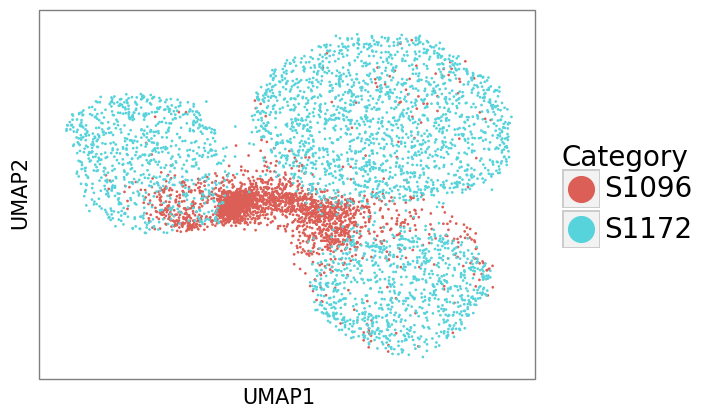

<ggplot: (2960436138882)>

In [21]:
plotUmap(x_embedded, "S1172", "S1096", n_label_base = input_trt_latent.shape[0])

In [35]:

onehot_indice_trt_other = np.tile(data_sciplex_onehot[indices_trt_removed][[21]], (len(input_trt_latent_other), 1, 1))
_, _, _, embdata_torch_other = model_g(torch.tensor(onehot_indice_trt_other).float().to(device))

## recon data
trt_onehot_other = std_model.standardize_z(embdata_torch_other.cpu().detach().numpy())
library_trt_latent_other = LSample[idx_trt_type_other]

In [38]:
onehot_indice_trt_otherTo = np.tile(data_sciplex_onehot[indices_trt_kept][[indice_trt]], (len(input_trt_latent_other), 1, 1))
_, _, _, embdata_torch_otherTo = model_g(torch.tensor(onehot_indice_trt_otherTo).float().to(device))
trt_onehot_otherTo = std_model.standardize_z(embdata_torch_otherTo.cpu().detach().numpy())

In [62]:
fake_latent_other, _ = perturbnet_model.trans_data(input_trt_latent_other, trt_onehot_other, 
                                                   trt_onehot_otherTo, 
                                                   library_trt_latent_other)

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


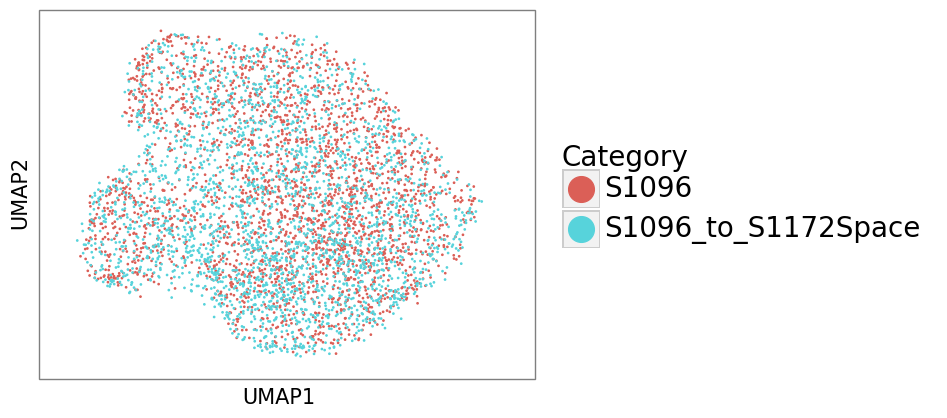

<ggplot: (2987099171705)>

In [67]:
x_embedded = tranUmap(input_trt_latent_other, fake_latent_other)
plotUmap(x_embedded, "S1096", "S1096_to_S1172Space", n_label_base = input_trt_latent_other.shape[0])

In [23]:

trt_type = 'S1096'
idx_trt_type_other = np.where(perturb_with_onehot_overall == trt_type)[0]
input_trt_latent_other = Zsample[idx_trt_type_other]

onehot_indice_trt_other = np.tile(data_sciplex_onehot[indices_trt_removed][[21]], (len(input_trt_latent_other), 1, 1))
_, _, _, embdata_torch_other = model_g(torch.tensor(onehot_indice_trt_other).float().to(device))

## recon data
trt_onehot_other = std_model.standardize_z(embdata_torch_other.cpu().detach().numpy())
library_trt_latent_other = LSample[idx_trt_type_other]

fake_latent, _ = perturbnet_model.sample_data(trt_onehot_other , library_trt_latent_other)

In [26]:
onehot_indice_trt_otherTo = np.tile(data_sciplex_onehot[indices_trt_kept][[indice_trt]], (len(input_trt_latent_other), 1, 1))
_, _, _, embdata_torch_otherTo = model_g(torch.tensor(onehot_indice_trt_otherTo).float().to(device))
trt_onehot_otherTo = std_model.standardize_z(embdata_torch_otherTo.cpu().detach().numpy())

In [27]:
fake_latent_other, _ = perturbnet_model.trans_data(fake_latent, trt_onehot_other, 
                                                   trt_onehot_otherTo, 
                                                   library_trt_latent_other)

In [28]:
x_embedded = tranUmap(fake_latent_other, fake_latent)

In [29]:
min_x, min_y = np.floor(x_embedded[:, 0].min()), np.floor(x_embedded[:, 1].min())
max_x, max_y = np.ceil(x_embedded[:, 0].max()), np.ceil(x_embedded[:, 1].max())

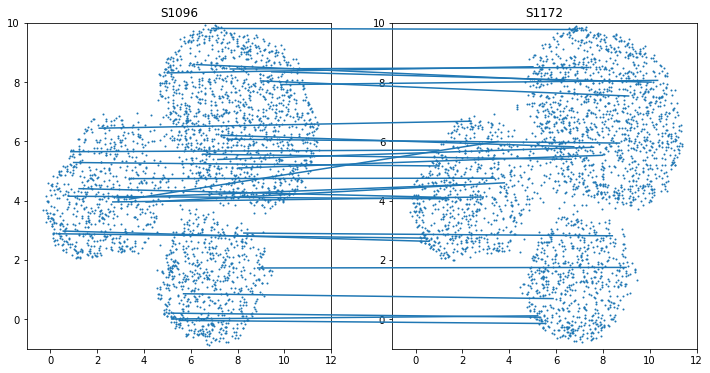

In [36]:
fig = plt.figure(figsize = (12, 6))

ax1 = plt.subplot(121)
plt.scatter(x_embedded[input_trt_latent_other.shape[0]:, 0], 
           x_embedded[input_trt_latent_other.shape[0]:, 1], s = 1)
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.title('S1096')
ax2 = plt.subplot(122)
plt.scatter(x_embedded[:input_trt_latent_other.shape[0], 0], 
            x_embedded[:input_trt_latent_other.shape[0], 1], s = 1)
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.title('S1172')
transFigure = fig.transFigure.inverted()
for i in range(30): #range(input_trt_latent_other.shape[0]):
    xy1 = transFigure.transform(ax2.transData.transform([x_embedded[i + input_trt_latent_other.shape[0], 0], 
                                                         x_embedded[i + input_trt_latent_other.shape[0], 1]]))
    xy2 = transFigure.transform(ax1.transData.transform([x_embedded[i, 0], x_embedded[i, 1]]))
    

    line = matplotlib.lines.Line2D((xy1[0],xy2[0]),(xy1[1],xy2[1]),
                                   transform = fig.transFigure)
    fig.lines.append(line)